In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
data = loadmat('ecg_dataset.mat')
print(data.keys())
print('------------------')
data

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
------------------


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Aug 26 17:46:48 2025',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-0.61 , -0.61 , -0.595, ..., -0.83 , -0.81 , -0.81 ],
        [-0.355, -0.375, -0.365, ...,  0.   ,  0.   ,  0.   ],
        [-0.26 , -0.26 , -0.25 , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [-0.23 , -0.235, -0.2  , ...,  0.   ,  0.   ,  0.   ],
        [ 0.15 ,  0.185,  0.195, ...,  0.   ,  0.   ,  0.   ],
        [-0.24 , -0.24 , -0.23 , ...,  0.   ,  0.   ,  0.   ]]),
 'y': array([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

In [4]:
X = data['X']
Y = data['y'].flatten()
classe, count = np.unique(Y,return_counts=True)
for c, n in zip(classe, count):
    print(f"Classe {c} : {n} échantillons")

Classe 0 : 5288 échantillons
Classe 1 : 111 échantillons
Classe 2 : 6 échantillons


index = 0
index = 2
index = 1148


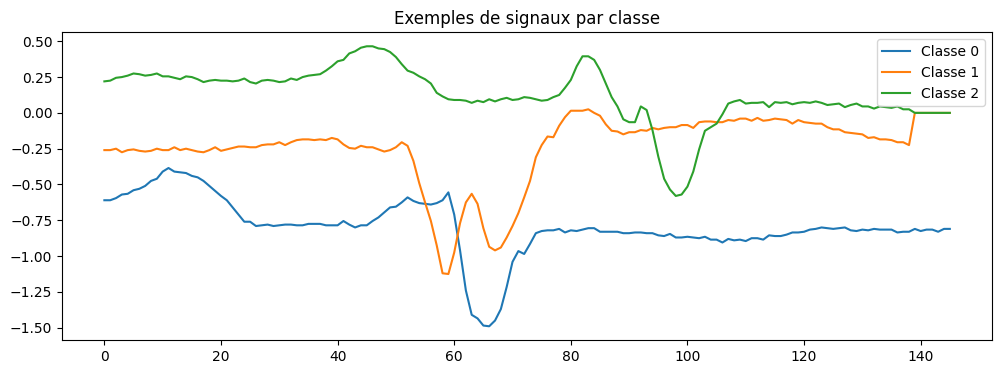

In [5]:
plt.figure(figsize=(12,4))
for c in [0, 1, 2]:
    idx = np.where(Y == c)[0][0] 
    print(f'index = {idx}')
    plt.plot(X[idx], label=f'Classe {c}')
plt.legend()
plt.title("Exemples de signaux par classe")
plt.show()

# Normalisation des données

In [6]:
#X_norm =(X- X.mean(axis=1, keepdims=True))/(X.std(axis=1, keepdims=True)+1e-8)
X_norm= (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True) + 1e-8)

X_norm

array([[0.79638008, 0.79638008, 0.80995474, ..., 0.59728506, 0.61538461,
        0.61538461],
       [0.71020408, 0.69387755, 0.70204081, ..., 0.99999999, 0.99999999,
        0.99999999],
       [0.75217391, 0.75217391, 0.76086956, ..., 0.97826086, 0.97826086,
        0.97826086],
       ...,
       [0.75879396, 0.75376884, 0.78894472, ..., 0.98994974, 0.98994974,
        0.98994974],
       [0.73636363, 0.76818181, 0.77727272, ..., 0.59999999, 0.59999999,
        0.59999999],
       [0.73762376, 0.73762376, 0.74752475, ..., 0.97524752, 0.97524752,
        0.97524752]])

# Recuperatioin de la classe d'entrainement classe N(0)

In [7]:
X_normal = X_norm[Y==0][:, :144]
X_anomaly_R = X_norm[Y==1][:, :144]
X_anomaly_V = X_norm[Y==2][:, :144]


In [8]:
X_training, X_validation = train_test_split(X_normal, test_size=0.2, random_state=42)
X_training = X_training[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_anomaly_R = X_anomaly_R[..., np.newaxis]
X_anomaly_V = X_anomaly_V[..., np.newaxis]


# construction de l'autoencodeur

In [9]:
data_input =(144, 1)
encoder = models.Sequential([
    layers.Input(shape=data_input),
    layers.Conv1D(16, kernel_size=7, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),  # réduction de dimension
    layers.Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
])

decoder = models.Sequential([
    layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(32, kernel_size=5, activation='relu', padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(16, kernel_size=7, activation='relu', padding='same'),
    layers.Conv1D(1, kernel_size=1, activation='linear', padding='same')  # sortie reconstruite
])

input_autoencodeur = layers.Input(shape = data_input)
data_encoded= encoder(input_autoencodeur)
data_decoded = decoder(data_encoded)

autoencodeur = models.Model(input_autoencodeur, data_decoded)

# compilation de l'autoencodeur

In [10]:
autoencodeur.compile(optimizer='adam', loss = 'mse')

#entrainement du models

In [11]:
training_history = autoencodeur.fit(
    X_training, X_training, epochs=40, batch_size=32,
    validation_data=(X_validation, X_validation),
    shuffle=True)

Epoch 1/40
133/133 [==============================] - 9s 37ms/step - loss: 0.0275 - val_loss: 5.3369e-04
Epoch 2/40
133/133 [==============================] - 4s 33ms/step - loss: 3.7961e-04 - val_loss: 3.1033e-04
Epoch 3/40
133/133 [==============================] - 4s 33ms/step - loss: 2.7083e-04 - val_loss: 2.4476e-04
Epoch 4/40
133/133 [==============================] - 4s 33ms/step - loss: 2.2111e-04 - val_loss: 2.0953e-04
Epoch 5/40
133/133 [==============================] - 4s 34ms/step - loss: 1.8769e-04 - val_loss: 1.8452e-04
Epoch 6/40
133/133 [==============================] - 4s 32ms/step - loss: 1.6450e-04 - val_loss: 1.5877e-04
Epoch 7/40
133/133 [==============================] - 4s 33ms/step - loss: 1.5271e-04 - val_loss: 1.4715e-04
Epoch 8/40
133/133 [==============================] - 4s 33ms/step - loss: 1.3271e-04 - val_loss: 1.3563e-04
Epoch 9/40
133/133 [==============================] - 4s 33ms/step - loss: 1.2999e-04 - val_loss: 1.2618e-04
Epoch 10/40
133/133 [==

# calcul du scroe d'anomalie(mse)

In [12]:
def anomaly_score(model, data):
    reconstructon = model.predict(data)
    errors = np.mean((data - reconstructon)**2, axis=(1,2))
    return errors

error_N = anomaly_score(autoencodeur, X_training)
error_R = anomaly_score(autoencodeur, X_anomaly_R)
error_V = anomaly_score(autoencodeur, X_anomaly_V)

print("============ Scroe d'anomalie =============")
print(f'Normales: {error_N}')
print(f'Anomalie R: {error_R}')
print(f'Anomalie V: {error_V}')

1/1 [==============================] - 0s 54ms/step
============ Scroe d'anomalie =============
Normales: [0.00025201 0.00023317 0.00025411 ... 0.00030282 0.00025261 0.00024298]
Anomalie R: [0.00062027 0.00042185 0.00068339 0.00061584 0.00038646 0.00038319
 0.00066019 0.00022761 0.00040127 0.00051215 0.00074507 0.00059671
 0.00044639 0.00050947 0.00053625 0.00059547 0.00020459 0.00022833
 0.00051639 0.00074108 0.00033434 0.00041016 0.00071526 0.00055845
 0.00061785 0.00052775 0.00058401 0.000385   0.00059134 0.0005412
 0.00049001 0.00045395 0.00049392 0.00021758 0.00054125 0.00037388
 0.00069845 0.00039004 0.00085755 0.00024768 0.00074994 0.00057789
 0.00042455 0.00063653 0.00043154 0.0002279  0.00045556 0.00020895
 0.00039596 0.00066634 0.00068031 0.00038895 0.00065925 0.00022201
 0.00016437 0.00027983 0.00038906 0.00050183 0.00047213 0.00051812
 0.00042743 0.00067037 0.00018651 0.00035846 0.00052857 0.00053879
 0.00063546 0.00033156 0.00041967 0.00045377 0.0003488  0.00056905
 0.0004

# Dertermination du seuil

In [13]:
seuil = np.percentile(error_N, 90)
print('========== Seuil de detection =============')
print(f'90eme percentil sur les données normales: {seuil:.6f}')
print(f'score_errorMAX: {np.max(error_N):.6f}')

========== Seuil de detection =============
90eme percentil sur les données normales: 0.000297
score_errorMAX: 0.006071


Visualition des score d'erreur

In [14]:
print("Erreurs max :")
print("  Normaux :", np.max(error_N))
print("  Anomalies R :", np.max(error_R))
print("  Anomalies V :", np.max(error_V))


Erreurs max :
  Normaux : 0.006070657293166474
  Anomalies R : 0.0012126136310376746
  Anomalies V : 0.00039371737810943273
